In [46]:
# from google.colab import drive
# drive.mount('/content/gdrive')
# %cd /content/gdrive/My\ Drive/masters

In [1]:
import os
import logging as log
from time import strftime
from copy import deepcopy
from torch import nn, optim
import torch.nn.functional as F
from utils.data_processing import *
from logger.logger import setup_logging
from utils.configs import BaseConf
from utils.utils import write_json, Timer, get_data_sub_paths, pshape, get_data_resolutions
from models.kangkang_fnn_models import KangFeedForwardNetwork, SimpleKangFNN
from dataloaders.flat_loader import FlatDataLoaders, MockLoader, MockLoaders
from datasets.flat_dataset import FlatDataGroup

from dataloaders.cell_loader import CellDataLoaders
from datasets.cell_dataset import CellDataGroup

from utils.metrics import PRCurvePlotter, ROCCurvePlotter, LossPlotter, PerTimeStepPlotter
from sklearn.metrics import accuracy_score, average_precision_score, roc_auc_score
from models.model_result import ModelResult, ModelMetrics, save_metrics
from utils.mock_data import mock_fnn_data_classification
from utils.plots import im
from trainers.generic_trainer import train_model
from models.kangkang_fnn_models import train_epoch_for_fnn
from utils.configs import BaseConf
from utils.metrics import best_threshold, get_y_pred
from dataloaders.grid_loader import GridDataLoaders
from datasets.grid_dataset import GridDataGroup
%matplotlib inline
from utils.mock_data import mock_fnn_data_classification
import matplotlib.pyplot as plt
from utils.plots import im
from utils.metrics import best_threshold, get_y_pred, get_y_pred_by_thresholds, best_thresholds
from models.model_result import ModelResult, ModelMetrics, save_metrics, compare_all_models,\
                                get_models_metrics, get_models_results
from pprint import pprint
from time import time



In [2]:
data_sub_paths = get_data_sub_paths()
pprint(np.sort(data_sub_paths))

# data_sub_path = 'T12H-X850M-Y880M_2013-01-01_2015-01-01'
data_sub_path = 'T1H-X1700M-Y1760M_2013-01-01_2015-01-01'
# data_sub_path = 'T1H-X850M-Y880M_2013-01-01_2015-01-01'
# data_sub_path = 'T24H-X255M-Y220M_2013-01-01_2015-01-01'
# data_sub_path = 'T24H-X425M-Y440M_2013-01-01_2015-01-01'
# data_sub_path = 'T24H-X850M-Y880M_2013-01-01_2015-01-01'
# data_sub_path = 'T24H-X850M-Y880M_2013-01-01_2017-01-01'
# data_sub_path = 'T24H-X85M-Y110M_2013-01-01_2015-01-01'
# data_sub_path = 'T3H-X850M-Y880M_2013-01-01_2015-01-01'
# data_sub_path = 'T6H-X850M-Y880M_2013-01-01_2015-01-01

array(['T12H-X850M-Y880M_2013-01-01_2015-01-01',
       'T1H-X1700M-Y1760M_2013-01-01_2015-01-01',
       'T1H-X850M-Y880M_2013-01-01_2015-01-01',
       'T24H-X255M-Y220M_2013-01-01_2015-01-01',
       'T24H-X425M-Y440M_2013-01-01_2015-01-01',
       'T24H-X850M-Y880M_2013-01-01_2015-01-01',
       'T24H-X850M-Y880M_2013-01-01_2017-01-01',
       'T24H-X85M-Y110M_2013-01-01_2015-01-01',
       'T3H-X850M-Y880M_2013-01-01_2015-01-01',
       'T6H-X850M-Y880M_2013-01-01_2015-01-01'], dtype='<U39')


In [49]:
conf = BaseConf()

conf.use_historic_average = True 
conf.use_classification = False
conf.use_crime_types = True

conf.seed = 3#int(time())  # idea is to have a constant seed while changing hyper parameters

conf.pad_with = 1 
conf.seq_len = 1

# conf.model_name = "LR (CMP)"
conf.model_name = f"LR (CMP) (pad={conf.pad_with},seq_len={conf.seq_len})"

if conf.use_historic_average:
    conf.model_name = f"{conf.model_name} (HistAvg)"

# conf.model_name = "LR (CMP+HistAvg)"
# conf.model_name = "LR (CMP)"
# conf.model_name = "LR (TMP)"
# conf.model_name = "LR (SPC)" # demog
# conf.model_name = "LR (ENV)"  # google street view

if conf.use_crime_types:
    conf.model_name = f"{conf.model_name} (crime-types)"
    
if not conf.use_classification:
    conf.model_name = f"{conf.model_name} (rgr)"
else:
    conf.model_name = f"{conf.model_name} (cls)"         

conf.data_path = f"./data/processed/{data_sub_path}/"

if not os.path.exists(conf.data_path):
    raise Exception(f"Directory ({conf.data_path}) needs to exist.")

conf.model_path = f"{conf.data_path}models/{conf.model_name}/"
os.makedirs(conf.data_path, exist_ok=True)
os.makedirs(conf.model_path, exist_ok=True)

# logging config is set globally thus we only need to call this in this file
# imported function logs will follow the configuration
setup_logging(save_dir=conf.model_path,
              log_config='./logger/standard_logger_config.json',
              default_level=log.INFO)

# SET NUMPY AND TORCH SEEDS LOADER SETUP
np.random.seed(conf.seed)
use_cuda = torch.cuda.is_available()
if use_cuda:
    torch.cuda.manual_seed(conf.seed)
else:
    torch.manual_seed(conf.seed)

device = torch.device("cuda:0" if use_cuda else "cpu")
log.info(f"Device: {device}")

conf.device = device

# SET THE HYPER PARAMETERS
conf.resume = False
conf.early_stopping = False
conf.max_epochs = 30
conf.dropout = 0#0.2
conf.weight_decay = 0#1e-8
conf.checkpoint = "best" # ["best"|"latest"]
conf.lr = 4e-3
conf.batch_size = 64

# CRIME DATA
conf.sub_sample_test_set = 0
conf.sub_sample_train_set =  1 # 0 #
conf.sub_sample_validation_set = 1 # 0 #


data_group = CellDataGroup(data_path=conf.data_path, conf=conf)
loaders = CellDataLoaders(data_group=data_group, conf=conf)
conf.freqstr = data_group.t_range.freqstr  

2019-11-25T00:27:17 | root | INFO | Device: cpu
2019-11-25T00:27:19 | root | INFO | 	t_range shape (17521,)
fitted historic average: step (24) and max_steps (-1)


In [50]:
# nn.ModuleDict
# nn.ModuleLinear

In [51]:
class LogisticRegression(nn.Module):
    def __init__(self, input_size, output_size):
        super(LogisticRegression, self).__init__()

        self.name = "LogReg"
        self.linear = nn.Linear(input_size, output_size)
        
        self.sigmoid = nn.Sigmoid()  # ensures output values always between one and zero

    def forward(self, x):
        out = self.linear(x)
        
        if not conf.use_classification:
            out = self.sigmoid(out)
        
        return out  
    
class LogisticRegression3(nn.Module):
    def __init__(self, spc_size, tmp_size, env_size, output_size):
        super(LogisticRegression3, self).__init__()

        self.name = "LogReg3"
        self.lin_spc = nn.Linear(spc_size, output_size)
        self.lin_tmp = nn.Linear(tmp_size, output_size)
        self.lin_env = nn.Linear(env_size, output_size)    
        self.lin_all = nn.Linear(3*output_size, output_size)

        
    def forward(self, spc_feats,tmp_feats,env_feats):        
        out_cat = torch.cat([self.lin_spc(spc_feats),
                             self.lin_tmp(tmp_feats),
                             self.lin_env(env_feats)], dim=-1)
        out_all = self.lin_all(out_cat)
        
        if not conf.use_classification:
            out_all = self.sigmoid(out_all)
        

        return out_all      

In [52]:
# Model setup  
train_set = loaders.train_loader.dataset
indices, spc_feats, tmp_feats, env_feats, target = train_set[train_set.min_index]
spc_size, tmp_size, env_size = spc_feats.shape[-1], tmp_feats.shape[-1], env_feats.shape[-1]

tmp_size = tmp_size*train_set.seq_len

if conf.use_classification:
    output_size = 2
    loss_function = nn.CrossEntropyLoss() 
else:
    output_size = 1
    loss_function = nn.MSELoss() 


model = LogisticRegression(input_size=spc_size+tmp_size+env_size,
                           output_size=output_size)

# model = LogisticRegression3(spc_size=spc_size,
#                             tmp_size=tmp_size,
#                             env_size=env_size,
#                             output_size=2)

model.to(conf.device)

parameters = model.parameters()

# important note: using weight decay (l2 penalty) can prohibit long term memory in LSTM networks
# - use gradient clipping instead
optimiser = optim.Adam(params=parameters, lr=conf.lr, weight_decay=conf.weight_decay)

##### RESUME LOGIC
if conf.resume:  # todo check if the files actually exist
    try:
        # resume from previous check point or resume from best validaton score checkpoint
        # load model state
        model_state_dict = torch.load(f"{conf.model_path}model_{conf.checkpoint}.pth",
                                      map_location=conf.device.type)
        model.load_state_dict(model_state_dict)
        
        # load optimiser state
        optimiser_state_dict = torch.load(f"{conf.model_path}optimiser_{conf.checkpoint}.pth",
                                          map_location=conf.device.type)
        optimiser.load_state_dict(optimiser_state_dict) 

        # new optimiser hyper-parameters
#         optimiser.param_groups[0]['lr'] = conf.lr
#         optimiser.param_groups[0]['weight_decay'] = conf.weight_decay

    except Exception as e:
        log.error(f"Nothing to resume from, training from scratch \n\t-> {e}")

In [53]:
def train_log_reg(model, optimiser, batch_loader, loss_fn, total_losses, conf):
    epoch_losses = []
    num_batches = batch_loader.num_batches
    for indices, spc_feats, tmp_feats, env_feats, targets in batch_loader:
        current_batch = batch_loader.current_batch
        
        # reformat for model input
        tmp_feats = np.swapaxes(tmp_feats,0,1)
        tmp_feats = np.reshape(tmp_feats, (tmp_feats.shape[0],-1))
        spc_feats = spc_feats[-1]
        env_feats = env_feats[-1]
        cmp_feats = np.concatenate((spc_feats,tmp_feats,env_feats),axis=-1)        
        targets = targets[-1]        
        
        
        # Transfer to PyTorch Tensor and GPU
        cmp_feats = torch.Tensor(cmp_feats).to(conf.device)
        
#         spc_feats = torch.Tensor(spc_feats).to(conf.device)  
#         tmp_feats = torch.Tensor(tmp_feats).to(conf.device)  
#         env_feats = torch.Tensor(env_feats).to(conf.device)  
        
        if conf.use_classification:
            targets = torch.LongTensor(targets[:,0]).to(conf.device)  
        else:
            targets = torch.Tensor(targets).to(conf.device)  # do not add [:,0]

        out = model(cmp_feats)
#         out = model(spc_feats)
#         out = model(tmp_feats)
#         out = model(env_feats)
#         out = model(spc_feats=spc_feats,
#                     tmp_feats=tmp_feats,
#                     env_feats=env_feats)
        
        loss = loss_fn(input=out, target=targets)
        epoch_losses.append(loss.item())
        total_losses.append(epoch_losses[-1])

        if model.training:  # not used in validation loops
            optimiser.zero_grad()
            loss.backward()
            optimiser.step()
            log.debug(f"Batch: {current_batch:04d}/{num_batches:04d} \t Loss: {epoch_losses[-1]:.4f}")
    mean_epoch_loss = np.mean(epoch_losses)
    return mean_epoch_loss


def evaluate_log_reg(model, batch_loader, conf):
    probas_pred = np.zeros(batch_loader.dataset.target_shape, dtype=np.float)
    y_true = batch_loader.dataset.targets[-len(probas_pred):]
    t_range = batch_loader.dataset.t_range[-len(probas_pred):]

    with torch.set_grad_enabled(False):
        model.eval()

        num_batches = batch_loader.num_batches
        for indices, spc_feats, tmp_feats, env_feats, targets in batch_loader:
            current_batch = batch_loader.current_batch
            
            # reformat for model input
            tmp_feats = np.swapaxes(tmp_feats,0,1)
            tmp_feats = np.reshape(tmp_feats, (tmp_feats.shape[0],-1))
            spc_feats = spc_feats[-1]
            env_feats = env_feats[-1]
            cmp_feats = np.concatenate((spc_feats,tmp_feats,env_feats),axis=-1)
            targets = targets[-1, :, 0]                        

            # Transfer to PyTorch Tensor and GPU
            cmp_feats = torch.Tensor(cmp_feats).to(conf.device)
                                     
            # used for log_reg_3
            spc_feats = torch.Tensor(spc_feats).to(conf.device)  
            tmp_feats = torch.Tensor(tmp_feats).to(conf.device)  
            env_feats = torch.Tensor(env_feats).to(conf.device)  

            out = model(cmp_feats)
#             out = model(tmp_feats)
#             out = model(env_feats)
#             out = model(spc_feats=spc_feats,
#                         tmp_feats=tmp_feats,
#                         env_feats=env_feats)
            
            if conf.use_classification:
                batch_probas_pred = F.softmax(out, dim=-1)[:, 1].cpu().numpy()  # select class1 prediction
            else:
                batch_probas_pred = out.cpu().numpy()

            for i, p in zip(indices, batch_probas_pred):
                n, c, h, w = i
                probas_pred[n, c, h, w] = p

    return y_true, probas_pred, t_range

## Training

2019-11-25T00:27:35 | root | INFO | 
 ====================== Training LR (CMP) (pad=3,seq_len=3) (HistAvg) (crime-types) (cls) ====================== 

2019-11-25T00:27:35 | root | INFO | 
 ====================== Config Values ====================== 
{'batch_size': 64,
 'checkpoint': 'best',
 'data_path': './data/processed/T1H-X1700M-Y1760M_2013-01-01_2015-01-01/',
 'device': device(type='cpu'),
 'dropout': 0,
 'early_stopping': False,
 'flatten_grid': True,
 'freqstr': 'H',
 'lr': 0.004,
 'max_epochs': 30,
 'model_name': 'LR (CMP) (pad=3,seq_len=3) (HistAvg) (crime-types) (cls)',
 'model_path': './data/processed/T1H-X1700M-Y1760M_2013-01-01_2015-01-01/models/LR '
               '(CMP) (pad=3,seq_len=3) (HistAvg) (crime-types) (cls)/',
 'n_channels': 3,
 'n_layers': 3,
 'n_steps_c': 3,
 'n_steps_p': 3,
 'n_steps_q': 3,
 'num_workers': 6,
 'pad_width': 0,
 'pad_with': 3,
 'resume': False,
 'seed': 3,
 'seq_len': 3,
 'shaper_threshold': 0,
 'shaper_top_k': -1,
 'shuffle': False,
 'sub_sa

2019-11-25T00:31:40 | root | INFO | 	Loss (Val): 		0.47716787
2019-11-25T00:31:40 | root | INFO | 	Loss (Val Best): 	0.47716787
2019-11-25T00:31:40 | root | INFO | 	Loss (Dif): 		0.07789656

2019-11-25T00:31:40 | root | INFO | Epoch: 0023/0030
2019-11-25T00:31:51 | root | INFO | 	Loss (Trn): 		0.39927046
2019-11-25T00:31:51 | root | INFO | 	Loss (Val): 		0.47714585
2019-11-25T00:31:51 | root | INFO | 	Loss (Val Best): 	0.47714585
2019-11-25T00:31:51 | root | INFO | 	Loss (Dif): 		0.07787538

2019-11-25T00:31:51 | root | INFO | Epoch: 0024/0030
2019-11-25T00:32:03 | root | INFO | 	Loss (Trn): 		0.39926970
2019-11-25T00:32:03 | root | INFO | 	Loss (Val): 		0.47712608
2019-11-25T00:32:03 | root | INFO | 	Loss (Val Best): 	0.47712608
2019-11-25T00:32:03 | root | INFO | 	Loss (Dif): 		0.07785638

2019-11-25T00:32:03 | root | INFO | Epoch: 0025/0030
2019-11-25T00:32:14 | root | INFO | 	Loss (Trn): 		0.39926901
2019-11-25T00:32:14 | root | INFO | 	Loss (Val): 		0.47710810
2019-11-25T00:32:14 

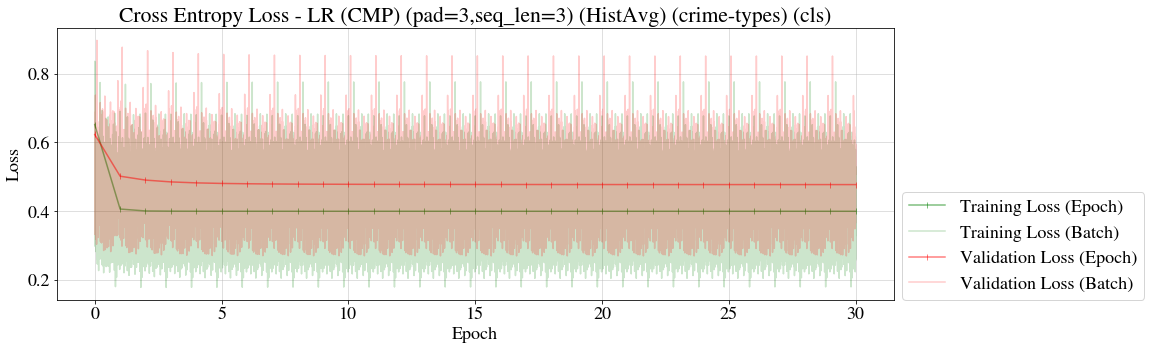

In [54]:
trn_epoch_losses, val_epoch_losses, stopped_early = train_model(model=model,
                                                                 optimiser=optimiser,
                                                                 loaders=loaders,
                                                                 train_epoch_fn=train_log_reg,
                                                                 loss_fn=loss_function,
                                                                 conf=conf)    

In [55]:
stopped_early

False

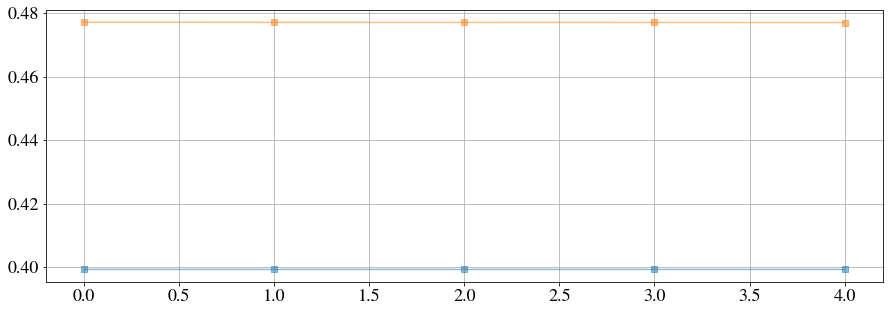

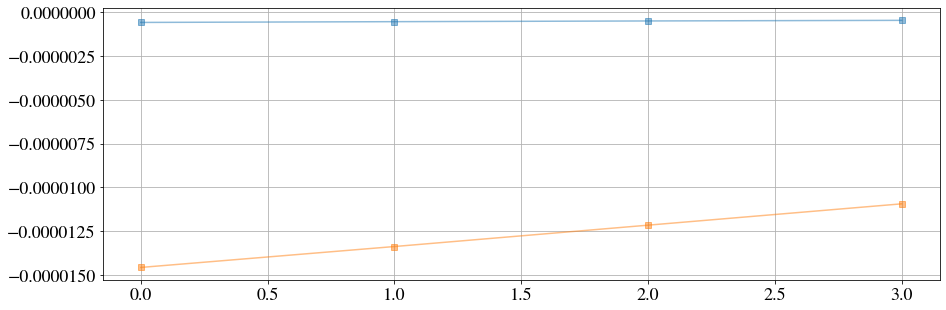

In [56]:
lim = 5

plt.figure(figsize=(15,5))
for x in [trn_epoch_losses, val_epoch_losses]:
    plt.plot(x[-lim:],marker='s',alpha=.5)
plt.grid(True)    
plt.show()

plt.figure(figsize=(15,5))
for x in [trn_epoch_losses, val_epoch_losses]:
    plt.plot(np.diff(x[-lim:]),marker='s',alpha=.5)
plt.grid(True)    
plt.show()

## Evaluation

In [57]:
# Load latest or best validation model
# conf.checkpoint = "latest"
conf.checkpoint = "best"

log.info(f"Loading model from checkpoint ({conf.checkpoint}) for evaluation")

# resume from previous check point or resume from best validaton score checkpoint
# load model state
model_state_dict = torch.load(f"{conf.model_path}model_{conf.checkpoint}.pth",
                                map_location=conf.device.type)
model.load_state_dict(model_state_dict)

2019-11-25T00:33:14 | root | INFO | Loading model from checkpoint (best) for evaluation


<All keys matched successfully>

In [58]:
conf.sub_sample_test_set = 0
conf.sub_sample_train_set = 0
conf.sub_sample_validation_set = 0

loaders = CellDataLoaders(data_group=data_group, conf=conf)

In [59]:
# todo set the train_loader to eval so that it does not subsample
trn_y_true, trn_probas_pred, trn_t_range = evaluate_log_reg(model=model,
                                                        batch_loader=loaders.train_loader,
                                                        conf=conf)

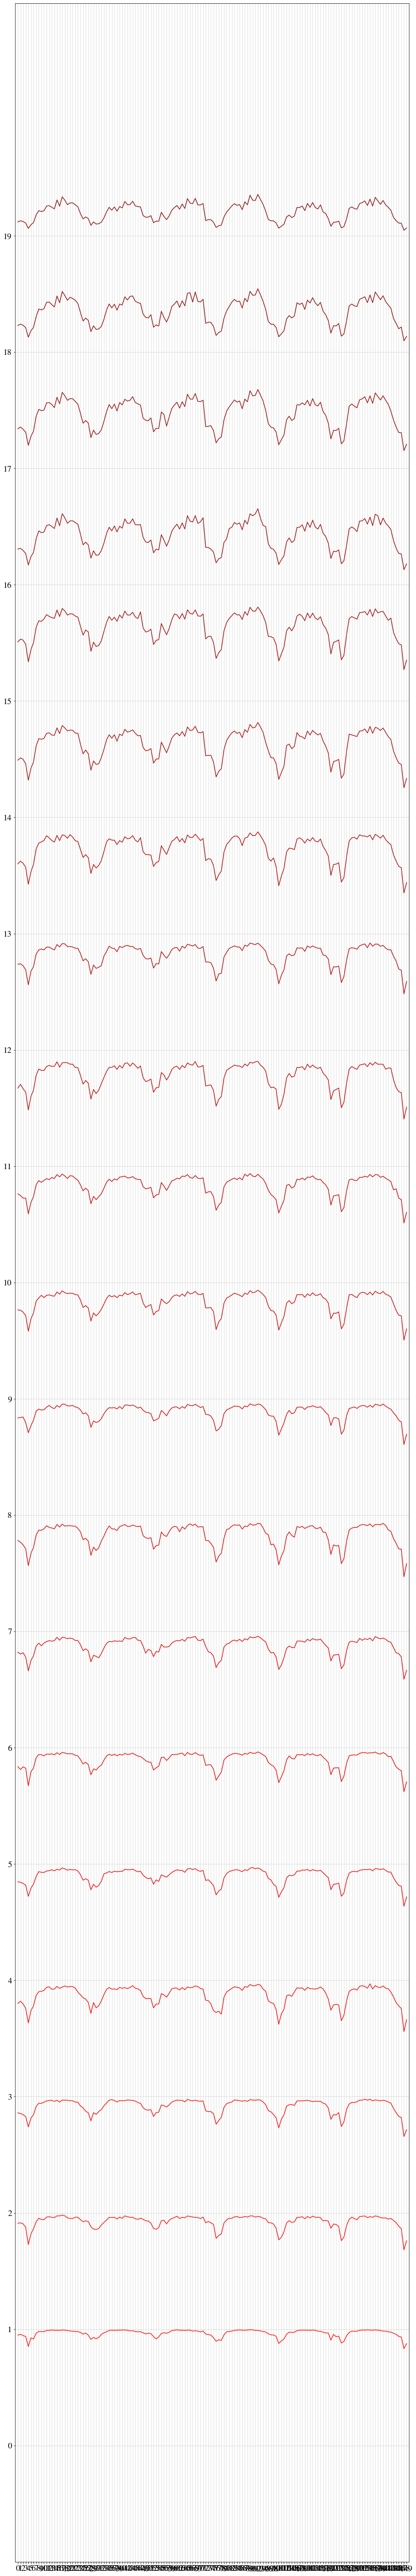

In [60]:
a = data_group.shaper.squeeze(trn_probas_pred)[:,0,data_group.sorted_indices]
# a = data_group.shaper.squeeze(trn_y_true)[:,0,data_group.sorted_indices]

lim = 150
a = a[:lim,0:-1:10]

plt.figure(figsize=(15,100))
I = a.shape[-1]

for i in range(I):
    r = 1-(0.5*(i)/(I+1))
    b = .1
    g = .1
    c = (r,.1,.1)
    plt.plot(a[:,i]+i,c=c)

plt.xlim(-1,len(a))
plt.ylim(-1,I+1)
plt.yticks(np.arange(a.shape[-1]))
plt.xticks(np.arange(lim))
plt.grid(True,alpha=.5)
plt.show()

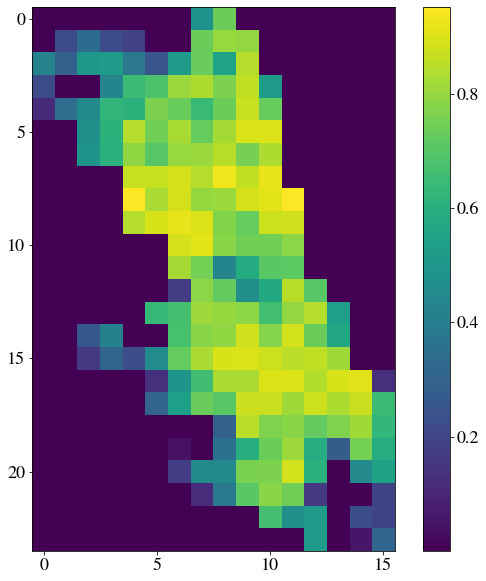

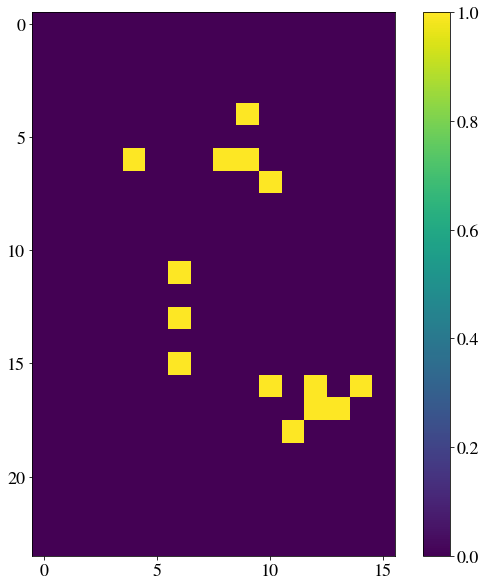

In [61]:
im(trn_probas_pred[:1,0].mean(0))
im(trn_y_true[:1,0].mean(0))

In [62]:
# have two values y_true_counts, y_true_class

In [63]:
if not conf.use_classification:
    trn_y_counts = np.copy(trn_y_true)
    trn_y_true[trn_y_true > 0] = 1

thresh = best_threshold(y_true=trn_y_true,
                        probas_pred=trn_probas_pred)

# thresholds = best_thresholds(y_true=trn_y_true,
#                              probas_pred=trn_probas_pred)


tst_y_true, tst_probas_pred, tst_t_range = evaluate_log_reg(model=model,
                                                                batch_loader=loaders.test_loader,
                                                                conf=conf)    

tst_y_pred = get_y_pred(thresh, tst_probas_pred)    
# tst_y_pred = get_y_pred_by_thresholds(thresholds, tst_probas_pred)    

tst_y_true = data_group.shaper.squeeze(tst_y_true)
tst_y_pred = data_group.shaper.squeeze(tst_y_pred)
tst_probas_pred = data_group.shaper.squeeze(tst_probas_pred)

2019-11-25T00:34:26 | root | INFO | f1_score: 0.3438036456883019 at index 653774, new threshold 0.9286338686943054


In [64]:
save_metrics(y_true=tst_y_true,
             y_pred=tst_y_pred,
             probas_pred=tst_probas_pred,
             t_range=tst_t_range,
             shaper=data_group.shaper, 
             conf=conf)   

/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


2019-11-25T00:35:06 | root | INFO | 
        MODEL METRICS
            Model Name: LR (CMP) (pad=3,seq_len=3) (HistAvg) (crime-types) (cls)
                MAE:                0.6756261120271297
                RMSE:               0.7351794402019753
                ROC AUC:            0.7487441863431231                
                Average Precision:  0.25552524427199214
                Precision:          0.23378906436603705
                Recall:             0.5091340352045275
                Accuracy:           0.7758370823767243
                MCC:                0.23032544155622645          
        


2019-11-25T00:35:07 | root | INFO | 
                                                        RMSE       MAE  \
Model Name                                                               
Historic Average                                    0.303039  0.128158   
ST-RESNET                                           0.303524  0.127056   
LR (CMP) (pad=1,seq_len=1) (HistAvg) (crime-typ...  0.733591  0.674848   
Ind-Hawkes Model                                    0.302050  0.131107   
LR (CMP) (pad=1,seq_len=1) (HistAvg) (crime-typ...  0.205082  0.181904   
LR (CMP) (pad=3,seq_len=3) (HistAvg) (crime-typ...  0.735179  0.675626   
LR (CMP) (pad=1,seq_len=1) (crime-types) (regre...  0.203845  0.180526   
LR (CMP) (pad=0,seq_len=1) (regressor)              0.252392  0.224005   
LR (CMP) (pad=0,seq_len=1) (crime-types) (regre...  0.253590  0.224802   
Hawkes General Model                                0.306032  0.127202   
Global Average                                      0.305278  0.130063   
L

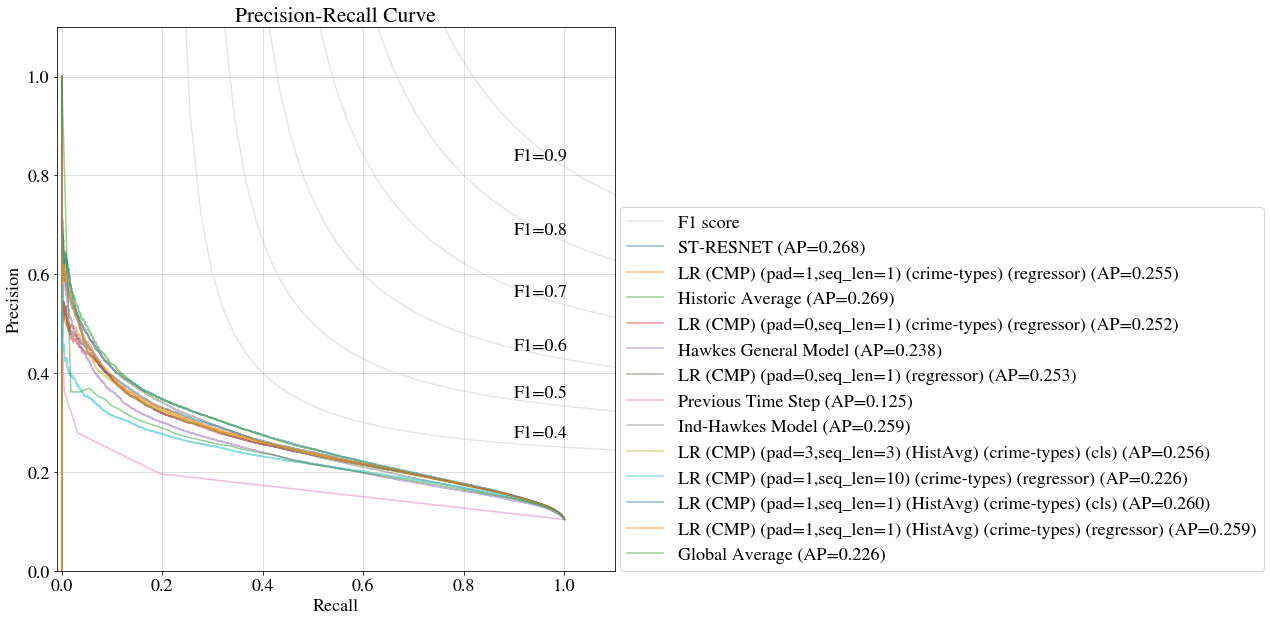

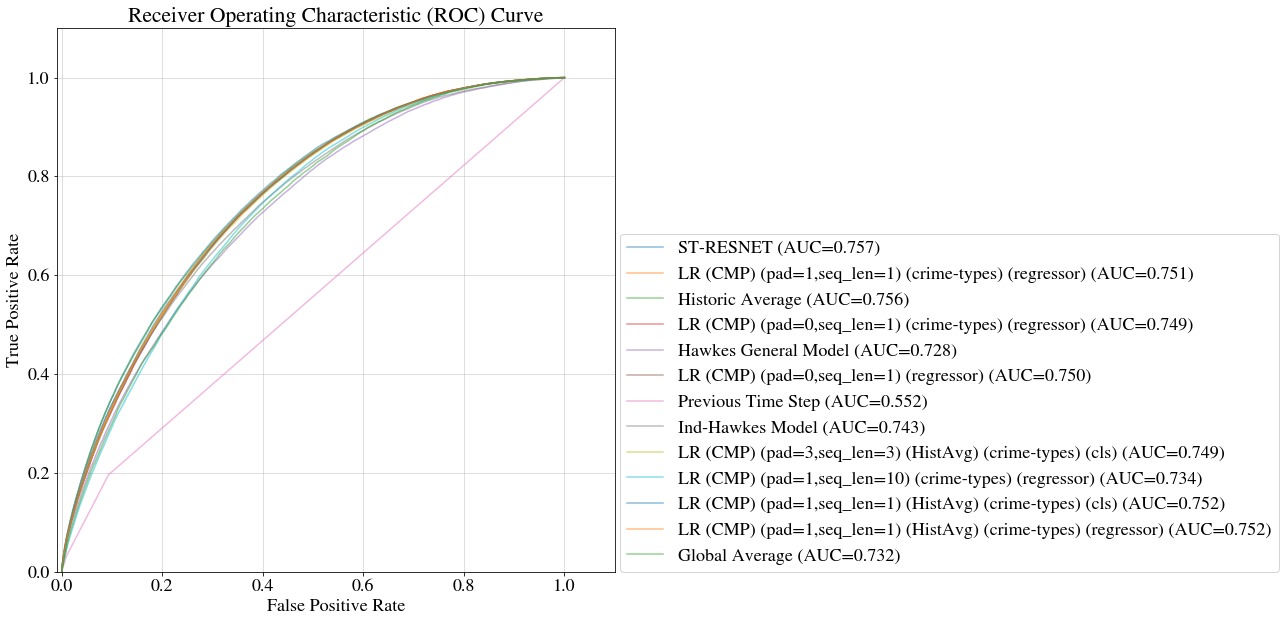

,RMSE,MAE,ROC AUC,Avg. Precision,Precision,Recall,F1 Score,Accuracy,Matthews Corrcoef
Model Name,,,,,,,,,
Historic Average,0.303039,0.128158,0.755682,0.268672,0.244779,0.503600,0.329434,0.787185,0.240860
ST-RESNET,0.303524,0.127056,0.756784,0.267786,0.251879,0.479152,0.330186,0.798204,0.240818
"LR (CMP) (pad=1,seq_len=1) (HistAvg) (crime-types) (cls)",0.733591,0.674848,0.751787,0.260324,0.237819,0.509592,0.324294,0.779563,0.235001
Ind-Hawkes Model,0.302050,0.131107,0.742548,0.259317,0.240920,0.471870,0.318980,0.790848,0.227100
"LR (CMP) (pad=1,seq_len=1) (HistAvg) (crime-types) (regressor)",0.205082,0.181904,0.751700,0.258602,0.233432,0.521431,0.322492,0.772576,0.233506
"LR (CMP) (pad=3,seq_len=3) (HistAvg) (crime-types) (cls)",0.735179,0.675626,0.748744,0.255525,0.233789,0.509134,0.320437,0.775837,0.230325
"LR (CMP) (pad=1,seq_len=1) (crime-types) (regressor)",0.203845,0.180526,0.751253,0.254729,0.238636,0.493175,0.321639,0.784057,0.231025
"LR (CMP) (pad=0,seq_len=1) (regressor)",0.252392,0.224005,0.749601,0.252899,0.233382,0.504640,0.319161,0.776509,0.228551
"LR (CMP) (pad=0,seq_len=1) (crime-types) (regressor)",0.253590,0.224802,0.749397,0.251880,0.229673,0.521972,0.318988,0.768649,0.229306


In [65]:
from utils.metrics import plot_roc_and_pr_curve

compare_all_models(conf.data_path)

2019-11-25T00:35:10 | root | INFO | 
                                                        RMSE       MAE  \
Model Name                                                               
Historic Average                                    0.303039  0.128158   
ST-RESNET                                           0.303524  0.127056   
LR (CMP) (pad=1,seq_len=1) (HistAvg) (crime-typ...  0.733591  0.674848   
Ind-Hawkes Model                                    0.302050  0.131107   
LR (CMP) (pad=1,seq_len=1) (HistAvg) (crime-typ...  0.205082  0.181904   
LR (CMP) (pad=3,seq_len=3) (HistAvg) (crime-typ...  0.735179  0.675626   
LR (CMP) (pad=1,seq_len=1) (crime-types) (regre...  0.203845  0.180526   
LR (CMP) (pad=0,seq_len=1) (regressor)              0.252392  0.224005   
LR (CMP) (pad=0,seq_len=1) (crime-types) (regre...  0.253590  0.224802   
Hawkes General Model                                0.306032  0.127202   
Global Average                                      0.305278  0.130063   
L

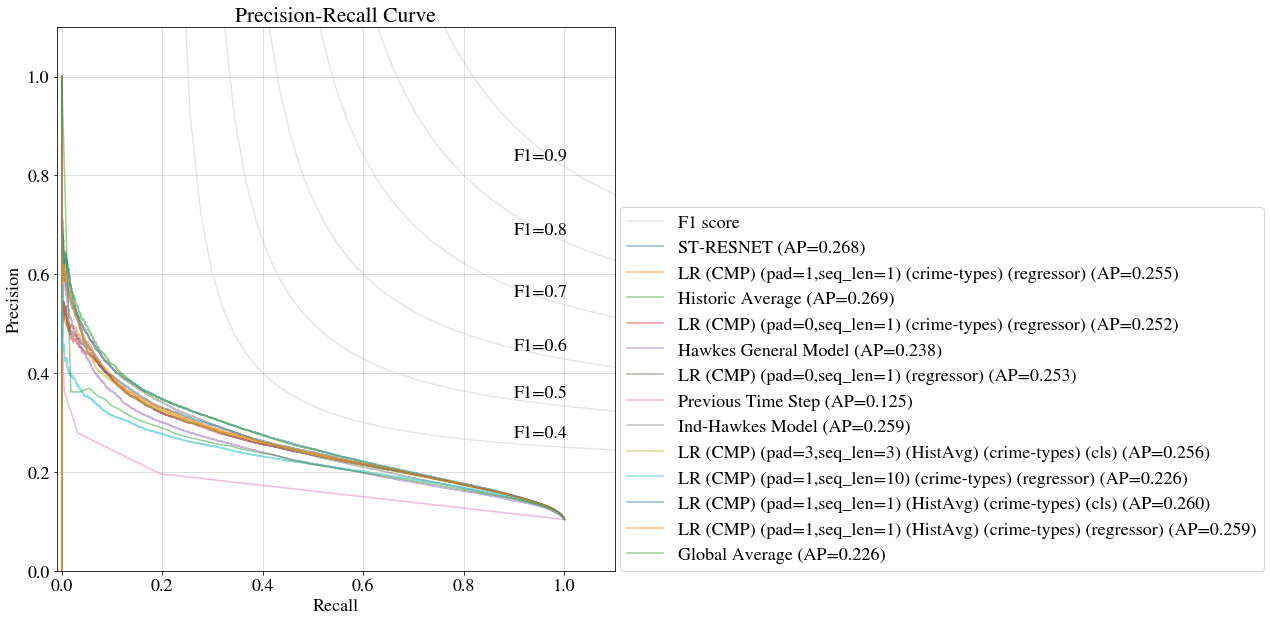

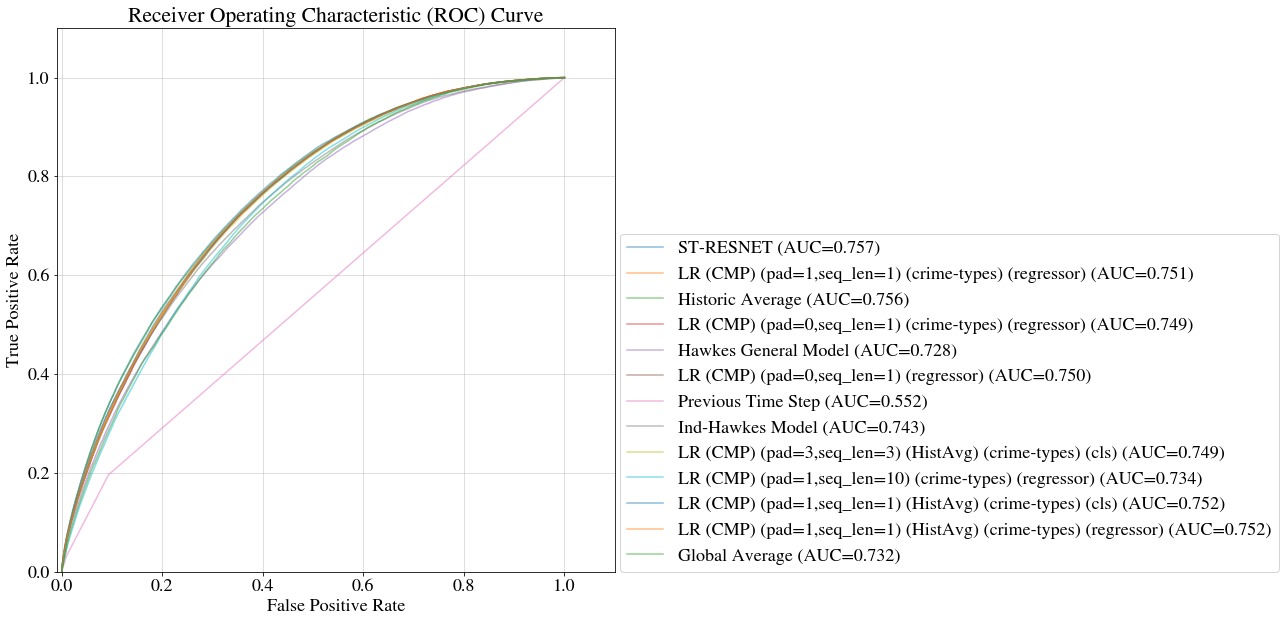

,RMSE,MAE,ROC AUC,Avg. Precision,Precision,Recall,F1 Score,Accuracy,Matthews Corrcoef
Model Name,,,,,,,,,
Historic Average,0.303039,0.128158,0.755682,0.268672,0.244779,0.503600,0.329434,0.787185,0.240860
ST-RESNET,0.303524,0.127056,0.756784,0.267786,0.251879,0.479152,0.330186,0.798204,0.240818
"LR (CMP) (pad=1,seq_len=1) (HistAvg) (crime-types) (cls)",0.733591,0.674848,0.751787,0.260324,0.237819,0.509592,0.324294,0.779563,0.235001
Ind-Hawkes Model,0.302050,0.131107,0.742548,0.259317,0.240920,0.471870,0.318980,0.790848,0.227100
"LR (CMP) (pad=1,seq_len=1) (HistAvg) (crime-types) (regressor)",0.205082,0.181904,0.751700,0.258602,0.233432,0.521431,0.322492,0.772576,0.233506
"LR (CMP) (pad=3,seq_len=3) (HistAvg) (crime-types) (cls)",0.735179,0.675626,0.748744,0.255525,0.233789,0.509134,0.320437,0.775837,0.230325
"LR (CMP) (pad=1,seq_len=1) (crime-types) (regressor)",0.203845,0.180526,0.751253,0.254729,0.238636,0.493175,0.321639,0.784057,0.231025
"LR (CMP) (pad=0,seq_len=1) (regressor)",0.252392,0.224005,0.749601,0.252899,0.233382,0.504640,0.319161,0.776509,0.228551
"LR (CMP) (pad=0,seq_len=1) (crime-types) (regressor)",0.253590,0.224802,0.749397,0.251880,0.229673,0.521972,0.318988,0.768649,0.229306


In [66]:
from utils.metrics import plot_roc_and_pr_curve

compare_all_models(conf.data_path)

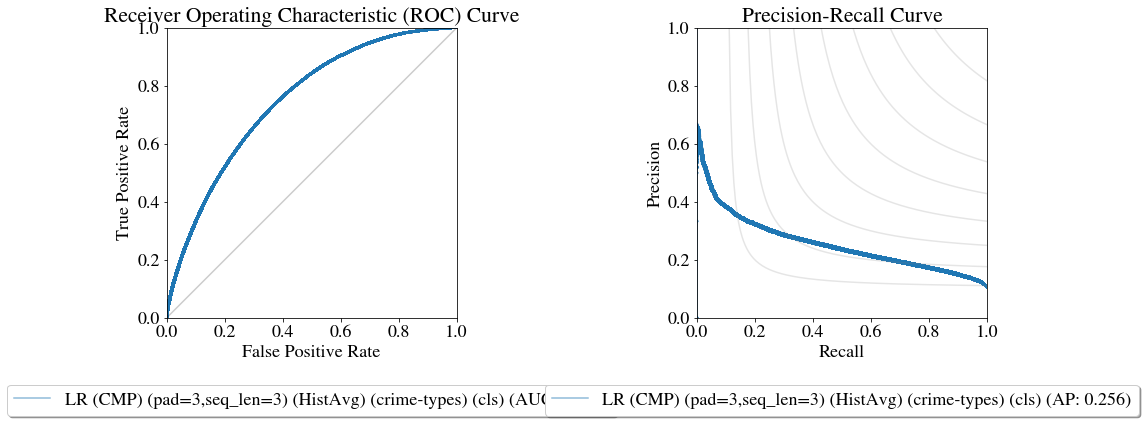

In [67]:
probas_pred_dict = {conf.model_name:tst_probas_pred.flatten()}
plot_roc_and_pr_curve(y_true=tst_y_true.flatten(), probas_pred_dict=probas_pred_dict)